# **Installing Dependencies**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **Dataset Pre-processing**

In [ ]:
df = pd.read_csv('software_quality_dataset.csv')

print("Dataset Shape:", df.shape)
print("\nFeature Info:")
print(df.info())


Dataset Shape: (1600, 9)

Feature Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Lines_of_Code          1520 non-null   float64
 1   Cyclomatic_Complexity  1600 non-null   int64  
 2   Num_Functions          1600 non-null   int64  
 3   Code_Churn             1520 non-null   float64
 4   Comment_Density        1520 non-null   float64
 5   Num_Bugs               1600 non-null   int64  
 6   Has_Unit_Tests         1600 non-null   object 
 7   Code_Owner_Experience  1600 non-null   int64  
 8   Quality_Label          1600 non-null   object 
dtypes: float64(3), int64(4), object(2)
memory usage: 112.6+ KB
None


# **EDA Class Balance**

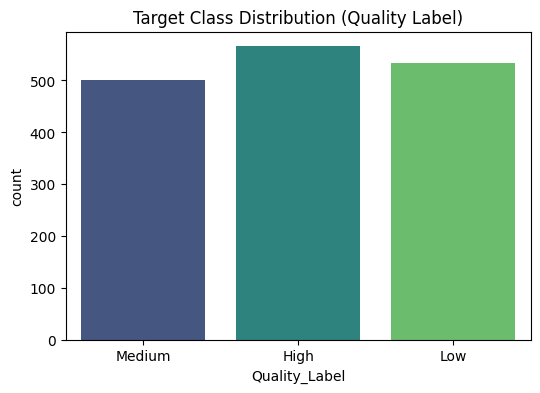

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Quality_Label', data=df, palette='viridis')
plt.title('Target Class Distribution (Quality Label)')
plt.show()


# **Correlation Heatmap**

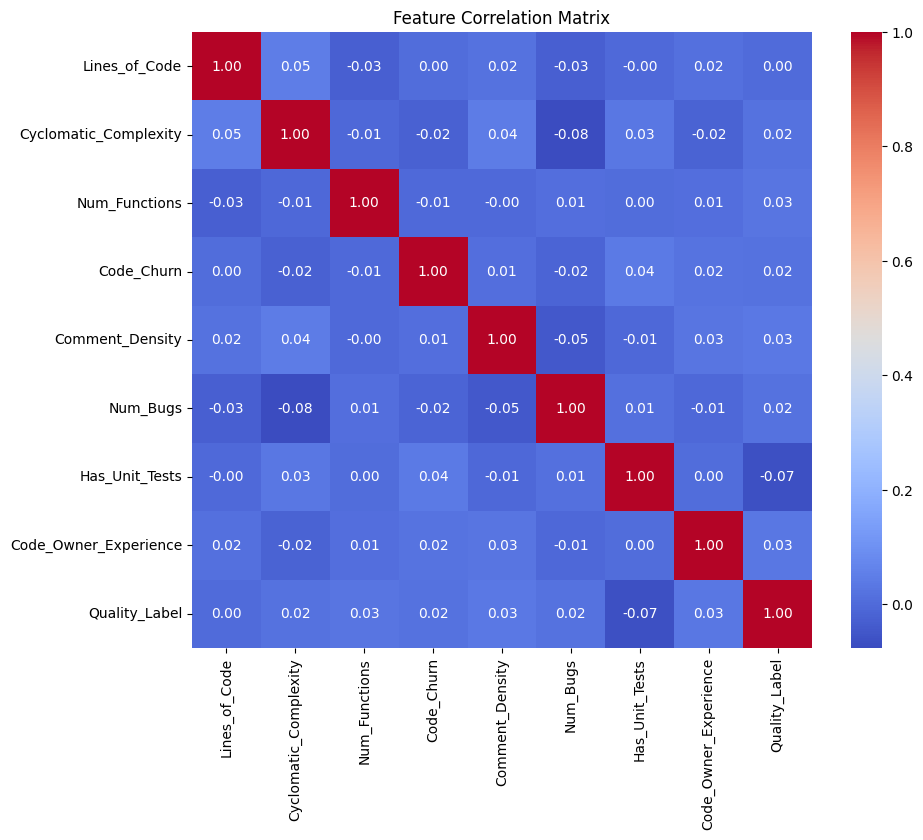

In [ ]:
df_corr = df.copy()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df_corr.select_dtypes(include='object').columns:
    df_corr[col] = le.fit_transform(df_corr[col])

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

# **Missing Value Handling and Feature Scaling**

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

num_cols = ['Lines_of_Code', 'Code_Churn', 'Comment_Density']
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])


df['Has_Unit_Tests'] = df['Has_Unit_Tests'].map({'Yes': 1, 'No': 0})

le_target = LabelEncoder()
df['Quality_Label_Encoded'] = le_target.fit_transform(df['Quality_Label'])
print(f"Target Classes Mapping: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")


feature_cols = ['Lines_of_Code', 'Cyclomatic_Complexity', 'Num_Functions', 'Code_Churn',
                'Comment_Density', 'Num_Bugs', 'Has_Unit_Tests', 'Code_Owner_Experience']

X = df[feature_cols]
y = df['Quality_Label_Encoded']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Target Classes Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


# **Dataset Splitting**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (1280, 8)
Testing shape: (320, 8)


# **Unsupervised Learning (K-Means Clustering)**

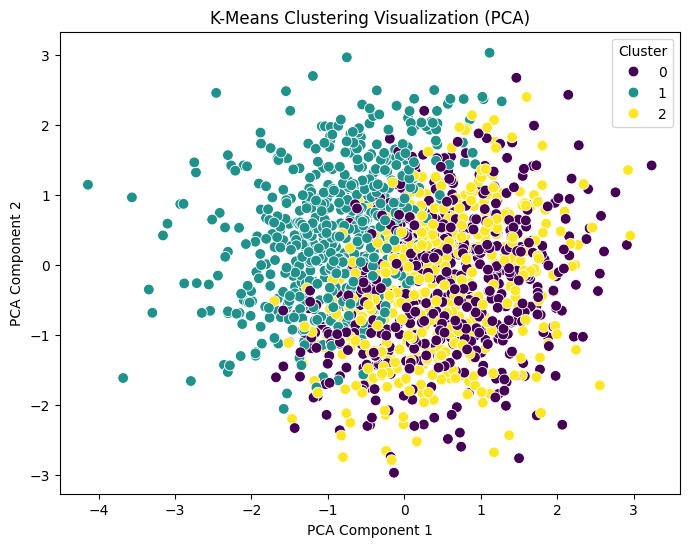

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=60)
plt.title('K-Means Clustering Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# **Model Training (Supervised)**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

models = {
    "Logistic Regression": LogisticRegression(multi_class='ovr', max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

results = {}
probas = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    results[name] = model.predict(X_test)
    probas[name] = model.predict_proba(X_test)
    print(f"{name} trained successfully.")

Logistic Regression trained successfully.
Naive Bayes trained successfully.
Neural Network trained successfully.


# **Model Evaluation & Comparison**

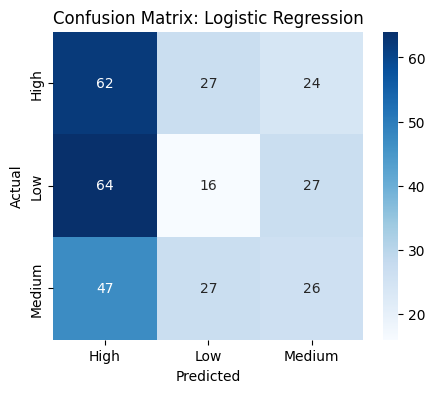

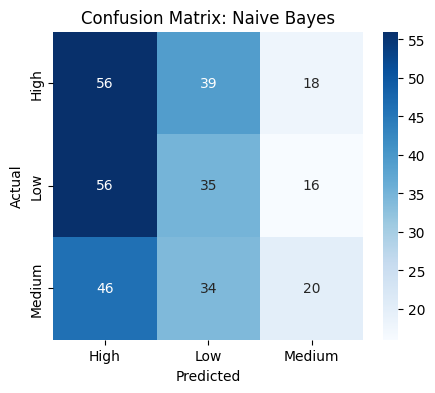

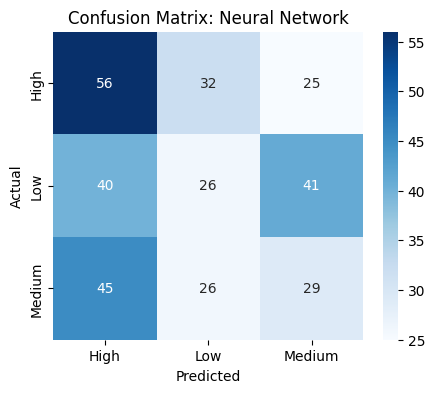

In [ ]:
from sklearn.metrics import confusion_matrix

for name, y_pred in results.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le_target.classes_, yticklabels=le_target.classes_)
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# **AUC Score**

In [ ]:
from sklearn.metrics import roc_auc_score
for name, model in models.items():

    y_prob = model.predict_proba(X_test)
    auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
    print(f"{name} ROC-AUC Score: {auc_score:.4f}")

Logistic Regression ROC-AUC Score: 0.5134
Naive Bayes ROC-AUC Score: 0.5313
Neural Network ROC-AUC Score: 0.4806


# **ROC Curve**

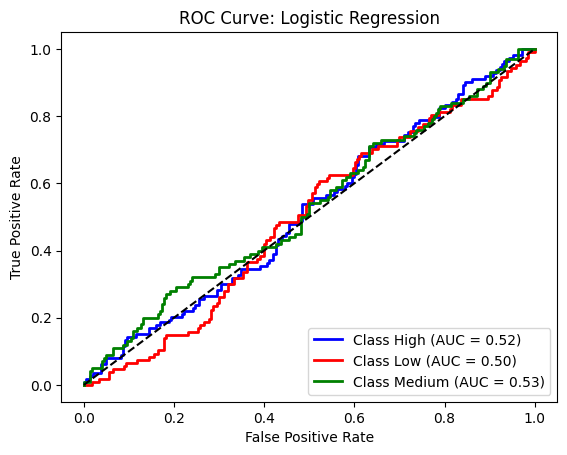

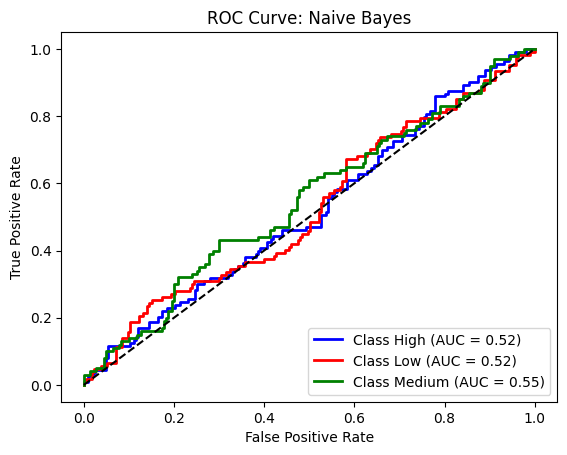

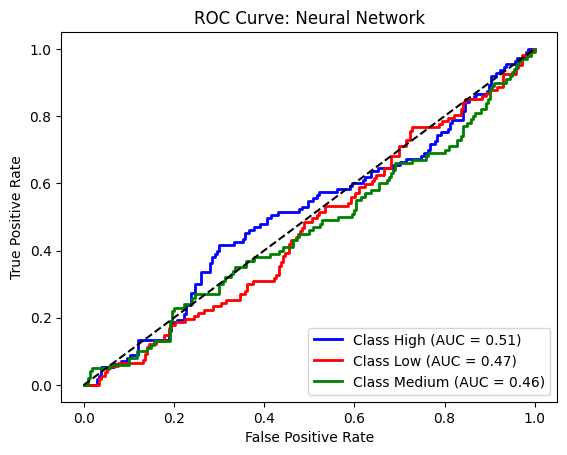

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

for name, y_prob in probas.items():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {le_target.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve: {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

# **Performance Comparison (Bar Chart)**

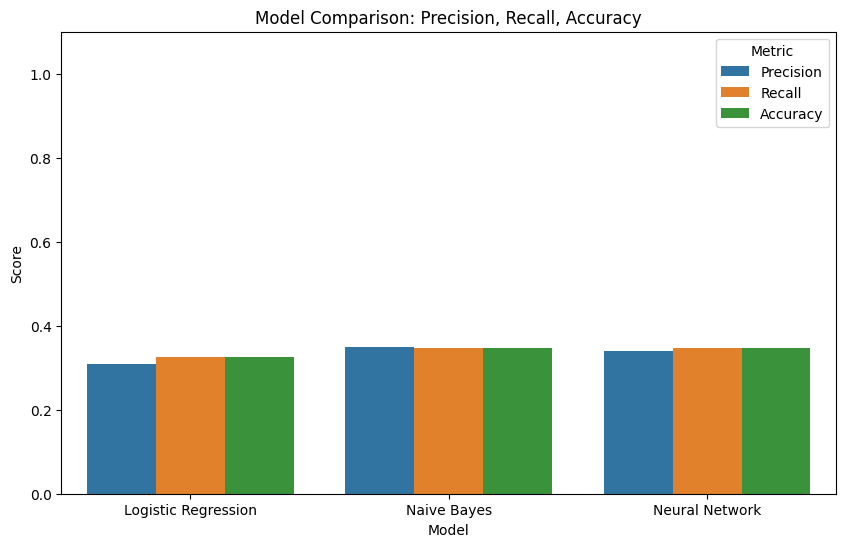

                 Model  Precision    Recall  Accuracy
0  Logistic Regression   0.308502  0.325000  0.325000
1          Naive Bayes   0.349261  0.346875  0.346875
2       Neural Network   0.339140  0.346875  0.346875


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

metrics_data = []

for name, y_pred in results.items():
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    metrics_data.append({'Model': name, 'Precision': prec, 'Recall': rec, 'Accuracy': acc})

metrics_df = pd.DataFrame(metrics_data)
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted)
plt.title('Model Comparison: Precision, Recall, Accuracy')
plt.ylim(0, 1.1)
plt.show()

print(metrics_df)